In [62]:
# imports
import pandas as pd
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pkg_resources
import seaborn as sns
from collections import Counter

In [4]:
# import the categories
category_names = pkg_resources.resource_filename('phynteny_utils', 'phrog_annotation_info/integer_category.pkl')
categories = pickle.load(open(category_names , 'rb'))

# import evlaluations on the test data
scores = np.array(pd.read_csv('/home/grig0076/phynteny_thresholding/ex_scores_df.tsv', sep = '\t', index_col = 0))
test_y = np.array(pd.read_csv('/home/grig0076/phynteny_thresholding/ex_test_y_df.tsv', sep = '\t', index_col = 0))
label = np.array([np.argmax(i) for i in test_y])
prediction = np.array([np.argmax(score) for idx, score in enumerate(scores)])

In [74]:
# use labels and predictions to make a joint distribution
# Here the rows are the true labels and the columns are the predicted categories 

arr = np.zeros((len(categories) -1, len(categories) - 1))

for i in range(len(label)): 
    
    arr[label[i] -1][prediction[i] -1] += 1 

<Axes: >

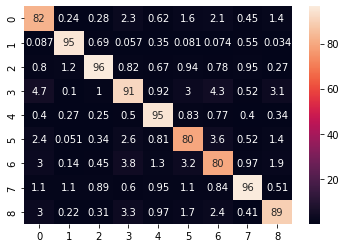

In [86]:
# rows sum to one in conf_mat
# this here is the actual cofusion matrix 
conf_mat = arr*100/arr.sum(axis=1)
sns.heatmap(conf_mat, annot=True)

<Axes: >

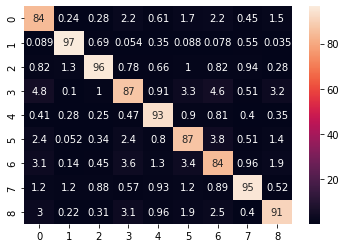

In [87]:
#rows sum to one in conf_mat 
rev_conf_mat = arr*100/arr.sum(axis=0)
sns.heatmap(rev_conf_mat, annot=True)

In [5]:
def count_critical_points(arr):
    return np.sum(np.diff(np.sign(np.diff(arr))) != 0)

def compute_confidence(scores, confidence_dict):
    """
    Function which computes the confidence of a Phynteny prediction
    Input is a vector of Phynteny scores
    """

    # get the prediction for each score
    score_predictions = np.array([np.argmax(score) for idx, score in enumerate(scores)])

    # make an array to store the confidence of each prediction
    confidence_out = np.zeros(len(scores))
    predictions_out = np.zeros(len(scores))

    # loop through each of potential categories
    for i in range(1,10):

        # get the scores relevant to the current category
        cat_scores = scores[score_predictions == i]

        # compute the kernel density estimates
        e_TP = np.exp(confidence_dict.get(categories.get(i)).get('kde_TP').score_samples(cat_scores[:,i].reshape(-1,1)))
        e_FP = np.exp(confidence_dict.get(categories.get(i)).get('kde_FP').score_samples(cat_scores[:,i].reshape(-1,1)))

        # fetch the number of TP and FP
        num_TP = confidence_dict.get(categories.get(i)).get('num_TP')
        num_FP = confidence_dict.get(categories.get(i)).get('num_FP')

        # compute the confidence scores
        conf_kde = (e_TP*num_TP)/(e_TP*num_TP + e_FP*num_FP)

        # save the scores to the output vector
        confidence_out[score_predictions == i ] = conf_kde
        predictions_out[score_predictions == i] = [i for k in range(len(conf_kde))]

    return predictions_out, confidence_out


In [8]:
predictions, confidence = compute_confidence(scores, confidence_dict)



,True,prediction,confidence
0,7,4.0,0.732839
1,7,7.0,0.989882
2,4,4.0,0.994013
3,4,5.0,0.372925
4,7,7.0,0.994434
...,...,...,...
98434,4,4.0,0.990263
98435,3,8.0,0.457498
98436,7,7.0,0.995646
98437,9,9.0,0.729836


In [136]:
categories

{4: 'DNA, RNA and nucleotide metabolism',
 2: 'connector',
 3: 'head and packaging',
 1: 'integration and excision',
 5: 'lysis',
 6: 'moron, auxiliary metabolic gene and host takeover',
 7: 'other',
 8: 'tail',
 9: 'transcription regulation',
 0: 'unknown function'}

In [138]:
confidence_df = pd.DataFrame({'True': label, 'prediction': predictions, 'confidence': confidence, 'Phynteny Score': [np.max(i) for i in scores], 'category': [categories.get(p) for p in predictions]})

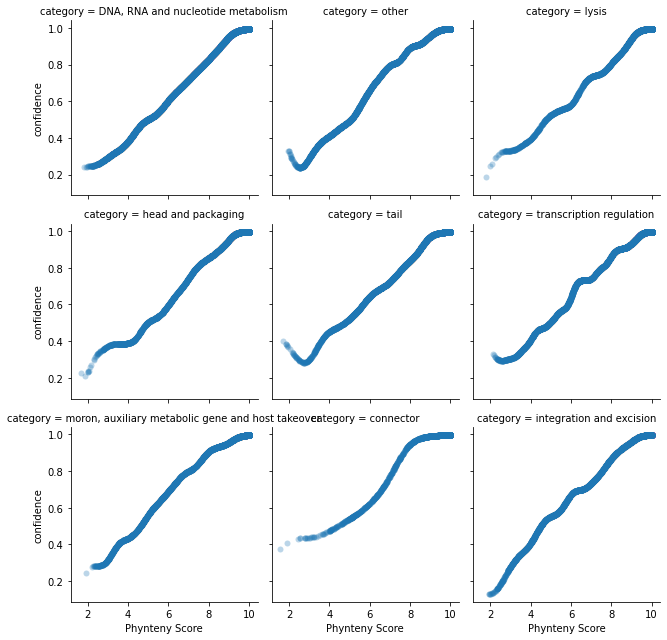

In [142]:
color_map =  {0: "#1b9e77", 1: "#d95f02", 2:"#7570b3", 3:"#e7298a", 4:"#66a61e",5:"#cab2d6",  6:"#a6761d", 7:"#e6ab02", 8:"#80b1d3"}

g = sns.FacetGrid(confidence_df, col = 'category', col_wrap=3) 
g.map(sns.scatterplot, 'Phynteny Score', 'confidence', linewidth=0, alpha=0.3)

## Generate the Kernel Density Estimators

Will need to generate this into a script which allows one to generate their own confidences 

In [46]:
vals.shape

(8500,)

In [43]:
# range of bandwiths to test
bandwidth = np.arange(0,5, 0.05)[1:]

# range over values to compute kernel density over
vals = np.arange(1.5, 10, 0.001)

# save a dictionary which contains all the information required to compute confidence scores
confidence_dict = dict()

# loop through the categories
for cat in range(1,10):

    # fetch the true labels of the predictions of this category
    this_labels = label[prediction == cat]

    # fetch the scores associated with these predictions
    this_scores = scores[prediction == cat]

    # separate false positives and true positives
    TP_scores = this_scores[this_labels == cat]
    FP_scores = this_scores[this_labels != cat]

    # loop through potential bandwidths
    for b in bandwidth:

        # compute the kernel density
        kde_TP = KernelDensity(kernel='gaussian', bandwidth=b)
        kde_TP.fit(TP_scores[:, cat].reshape(-1,1))
        e_TP = np.exp(kde_TP.score_samples(vals.reshape(-1,1)))

        kde_FP = KernelDensity(kernel='gaussian', bandwidth=b)
        kde_FP.fit(FP_scores[:, cat].reshape(-1,1))
        e_FP = np.exp(kde_FP.score_samples(vals.reshape(-1,1)))

        conf_kde = (e_TP*len(TP_scores))/(e_TP*len(TP_scores) + e_FP*len(FP_scores))

        if count_critical_points(conf_kde) <= 1:
            break

    #save the best estimators
    confidence_dict[categories.get(cat)] = {"kde_TP": kde_TP,
                                            "kde_FP": kde_FP,
                                            "num_TP": len(TP_scores),
                                            "num_FP": len(FP_scores),
                                            "bandwidth": b}



# generate a pickle for this 
pickle.dump(confidence_dict, open('confidence_dict.pkl', 'rb'))


KeyboardInterrupt: 

In [236]:
# declare the bandwidth
b = 0.48

# pull out the instances of a specific label getting prediction
cat = 1
this_labels = label[prediction == cat]
this_scores = scores[prediction == cat]

TP_scores = this_scores[this_labels == cat]
FP_scores = this_scores[this_labels != cat]

vals = np.arange(1.5, 10, 0.01)

In [237]:
kde_TP = KernelDensity(kernel='gaussian', bandwidth=b)
kde_TP.fit(TP_scores[:, cat].reshape(-1,1))
e_TP = np.exp(kde_TP.score_samples(vals.reshape(-1,1)))

kde_FP = KernelDensity(kernel='gaussian', bandwidth=b)
kde_FP.fit(FP_scores[:, cat].reshape(-1,1))
e_FP = np.exp(kde_FP.score_samples(vals.reshape(-1,1)))

conf_kde = (e_TP*len(TP_scores))/(e_TP*len(TP_scores) + e_FP*len(FP_scores))

In [238]:
def count_critical_points(arr):
    return np.sum(np.diff(np.sign(np.diff(arr))) != 0)

count_critical_points(conf_kde)

0

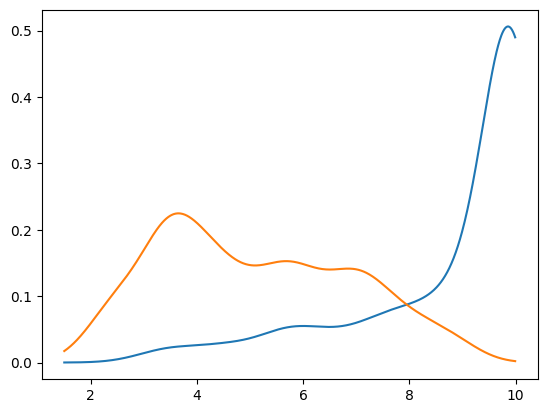

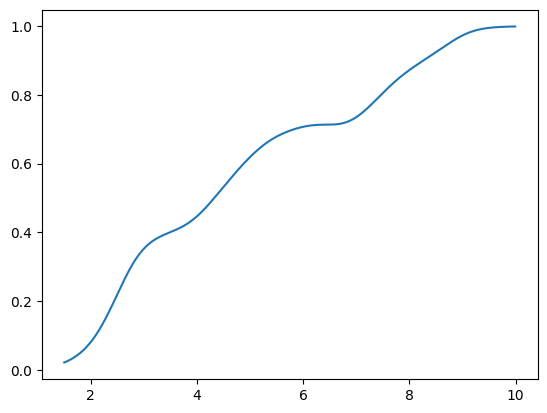

In [239]:
plt.plot(vals,e_TP)
plt.plot(vals, e_FP)
plt.show()

plt.plot(vals, conf_kde) # blue
plt.show()

In [ ]:
# use this confidence estimate as our Phynteny Score

# need to generate a grid search for selecting the optimal bandwidth

# confidence scores get recalibrated using the kernel density

# you can then give the model a confidence estimate

# this means that we need to keep the confidence estimators in the model
# to find it - snap to the closest score and then compute